# Model

In [4]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model

In [5]:
train_dir = 'C:/Users/YYJ/Desktop/ddata/448/'     #载入存放数据的位置
test_dir = 'C:/Users/YYJ/Desktop/ddata/448/'
val_dir ='C:/Users/YYJ/Desktop/ddata/448/'

# 数据处理
def process_image(image):
    ret,bi_inv = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV) #ret是指阈值，在图像处理中代表颜色转换的临界值
    return bi_inv, image

def create_data(tdir_, type_, frm, to, t_data): # tdir代表的是数据的存放位置，type_代表的是数据是否包含有裂缝，t_data是产生数据的种类
    colored_data=[]
    bi_inv_data=[]
    #print('Working On '+t_data+' Data : '+type_ +'\n')
    rng = ["%05d" % x for x in range(frm, to+1)]
    for i in rng:
        dir_ =tdir_+type_+'/'+i+'.jpg'
        image = cv2.imread(dir_, 0)
        bi_inv, colored_img = process_image(image)
        colored_data.append(colored_img)
        bi_inv_data.append(bi_inv)   
        
    #print('Images Processed from '+rng[0]+' to '+rng[len(rng)-1]+'\n')    
    return colored_data, bi_inv_data #返回原始的图片数据和处理后的图片数据

In [ ]:
#准备训练数据
train_data_colr= []
train_labels=[]
train_data_inv = []

train_data_colr_pos, train_data_inv_pos=  create_data(train_dir, 'Cracks', 1, 200, 'Training') #有裂缝的数据

for i in range(0, len(train_data_colr_pos)):
    train_data_colr.append(train_data_colr_pos[i])
    train_data_inv.append(train_data_inv_pos[i])
    train_labels.append(1)

train_data_colr_neg, train_data_inv_neg=  create_data(train_dir, 'NonCracks', 1, 200, 'Training') #没有裂缝的数据

for i in range(0, len(train_data_colr_neg)):
    train_data_colr.append(train_data_colr_neg[i])
    train_data_inv.append(train_data_inv_neg[i])
    train_labels.append(0)


final_train_colr = np.array(train_data_colr).reshape(((len(train_data_colr), 227, 227, 1)))        
final_train_inv = np.array(train_data_inv).reshape(((len(train_data_inv), 227, 227, 1)))   

print('Shape of Training Data : '+str(final_train_colr.shape))



#准备验证数据
val_data_colr= []
val_labels=[]
val_data_inv = []

val_data_colr_pos, val_data_inv_pos=  create_data(val_dir, 'Cracks', 201, 230, 'Validation')


for i in range(0, len(val_data_colr_pos)):
    val_data_colr.append(val_data_colr_pos[i])
    val_data_inv.append(val_data_inv_pos[i])
    val_labels.append(1)

val_data_colr_neg, val_data_inv_neg=  create_data(val_dir, 'NonCracks', 201, 230, 'Validation')

for i in range(0, len(val_data_colr_neg)):
    val_data_colr.append(val_data_colr_neg[i])
    val_data_inv.append(val_data_inv_neg[i])
    val_labels.append(0)
    
final_val_colr = np.array(val_data_colr).reshape(((len(val_data_colr), 227, 227, 1)))    
final_val_inv = np.array(val_data_inv).reshape(((len(val_data_inv), 227, 227, 1)))   

print('Shape of Validation Data : '+str(final_val_colr.shape))

#准备测试数据
test_data_colr= []
test_labels=[]
test_data_inv = []

test_data_colr_pos, test_data_inv_pos=  create_data(test_dir, 'Cracks', 231, 250, 'Testing')


for i in range(0, len(test_data_colr_pos)):
    test_data_colr.append(test_data_colr_pos[i])
    test_data_inv.append(test_data_inv_pos[i])
    test_labels.append(1)

test_data_colr_neg, test_data_inv_neg=  create_data(test_dir, 'NonCracks', 231, 250, 'Testing')

for i in range(0, len(test_data_colr_neg)):
    test_data_colr.append(test_data_colr_neg[i])
    test_data_inv.append(test_data_inv_neg[i])
    test_labels.append(0)
    
final_test_colr = np.array(test_data_colr).reshape(((len(test_data_colr), 227, 227, 1)))    
final_test_inv = np.array(test_data_inv).reshape(((len(test_data_inv), 227, 227, 1)))   

print('Shape of Testing Data : '+str(final_test_colr.shape))


#构建卷积神经网络

input_shape = (227, 227, 1)
Wh = 3
Ww = 3
model = Sequential()
model.add(Conv2D(input_shape=input_shape , data_format="channels_last", kernel_size=(Wh,Ww), filters=32, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

batch_size = 10
epochs = 30
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(final_train_inv, train_labels, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(final_val_inv, val_labels))




score=model.evaluate(final_test_inv, test_labels)
print('Final Accuracy : ', score[1]*100, "%" )
print('Final Loss : ', score[0])

In [6]:
def predict_image_util(final_pred_inv):
    img_test = (final_pred_inv[0].reshape((1, 227, 227, 1)))  
    raw_predicted_label = model.predict(img_test, batch_size=None, verbose=0, steps=None)[0][0] #判断与类别的相似度
    
    predicted_label=1;    
    if(raw_predicted_label<0.8):
        predicted_label=0
        
    predicted_label_str='Crack'    
    if(predicted_label==0):
        predicted_label_str='No Crack'
        
    #print('Raw Predicted Label(Numeric): '+str(raw_predicted_label))
    #print('\nPredicted Label : '+predicted_label_str)
    return predicted_label_str




from_data_dir = 'C:/Users/YYJ/Desktop/ddata/448/'  #Directory

def predict_image2(type_, frm, to):
    
    pred_data_colr_, pred_data_inv_ = create_data(from_data_dir, type_, frm, to, 'Predictable')
    plt.imshow(pred_data_colr_[0],'gray')
    pred_data_colr =[]
    pred_data_inv = []
    
    pred_data_inv.append(pred_data_inv_[0])
    pred_data_colr.append(pred_data_colr_[0])
    
    final_pred_colr = np.array(pred_data_colr).reshape(((len(pred_data_colr), 227, 227, 1)))  
    final_pred_inv = np.array(pred_data_inv).reshape(((len(pred_data_inv), 227, 227, 1)))
    predict_image_util(final_pred_inv)
    string_label = predict_image_util(final_pred_inv)
    return string_label

In [ ]:
model.save_weights('third_30_weights.h5')
model.save('third_30.h5')


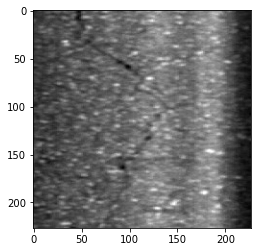

In [13]:
model = load_model('third_30.h5')
for i in range(1,21):
    if predict_image2('demo_data',i,i) == 'Crack':
        demo_dir_ = 'C:/Users/YYJ/Desktop/ddata/448/demo_data/'+'%05d' % i + '.jpg'
        demo_data_pic = cv2.imread(demo_dir_, 0)
        dir_origin_pic = 'C:/Users/YYJ\Desktop/roaddectect/Data_Tagging_master/original_data/'+'%05d' % i + '.jpg'
        cv2.imwrite(dir_origin_pic,demo_data_pic)

# Detect

In [14]:
import os
import cv2
import tkinter as tk
global point1,point2
global ensure,pressure2
global crack_type
def crack1():
    global crack_type
    crack_type = 1
    
def crack2():
    global crack_type
    crack_type = 2
    
def crack3():
    global crack_type
    crack_type = 3
    
def write(entry2,win):
    global pressure2
    pressure2 = entry2.get()
    win.destroy()
def confirm(confirm,win):
    global ensure
    ensure = confirm
    win.destroy()
def createWinSure():
    win=tk.Tk()
    label=tk.Label(win,text="确认图像标注正确",bg="white",fg="black")
    label.pack()
    buttony=tk.Button(win,text="正确",command=lambda:confirm(True,win)) #收到消息执行这个函数
    buttony.pack()#加载到窗体，
    buttonn=tk.Button(win,text="错误",command=lambda:confirm(False,win)) #收到消息执行这个函数
    buttonn.pack()#加载到窗体，
    win.mainloop()
def createWinWri():
    win=tk.Tk()
    label=tk.Label(win,text="请选择道路病害类型:",bg="white",fg="black")
    label.pack()
    button=tk.Button(win,text="横向裂缝",command=lambda:crack1()) 
    button.pack()
    button=tk.Button(win,text="纵向裂缝",command=lambda:crack2()) 
    button.pack()
    button=tk.Button(win,text="块状裂缝",command=lambda:crack3()) 
    button.pack()
    #entry=tk.Entry(win,width=50,bg="white",fg="black")
    #entry.pack()
    label2=tk.Label(win,text="请输入比例尺(像素点:厘米):",bg="white",fg="black")
    label2.pack()
    entry2=tk.Entry(win,width=50,bg="white",fg="black")
    entry2.pack()
    button=tk.Button(win,text="确认",command=lambda:write(entry2,win)) #收到消息执行这个函数
    button.pack()#加载到窗体，
    win.mainloop()
def on_mouse(event, x, y, flags, param):
    global point1,point2
    global ensure
    global pressure2
    img = param[0]
    index = param[1]
    img2 = img.copy()
    if event == cv2.EVENT_LBUTTONDOWN:         #左键点击
        point1 = (x,y)
        cv2.circle(img2, point1, 10, (0,255,0), 5)
        cv2.imshow('image', img2)
    elif event == cv2.EVENT_MOUSEMOVE and (flags & cv2.EVENT_FLAG_LBUTTON):               #按住左键拖曳
        cv2.rectangle(img2, point1, (x,y), (255,0,0), 5)
        cv2.imshow('image', img2)
    elif event == cv2.EVENT_LBUTTONUP:         #左键释放
        point2 = (x,y)
        cv2.rectangle(img2, point1, point2, (0,0,255), 5) 
        #ensure = raw_input("确认图像标注正确,输入y or n :")
        createWinSure()
        if ensure:
            createWinWri()
            #pressure = raw_input("请输入裂缝类型:")
            cv2.imwrite('./generate_data/'+str(index)+'_'+str(point1[0])+'_'+str(point1[1])+'_'+str(point2[0])+'_'+str(point2[1])+'_'+str(crack_type)+'_'+pressure2[2:]+'.jpg', img2)
            cv2.imshow('image', img2)
            cv2.destroyAllWindows()
        else :
            print ('请在图片上重新框选!')
def main():
    for root, dirs, files in os.walk('./original_data/'): 
        for i in range(0,len(files)):
            img = cv2.imread('./original_data/'+files[i])
            cv2.namedWindow('image')
            cv2.setMouseCallback('image', on_mouse,[img,i+1])
            cv2.imshow('image', img)
            cv2.waitKey(0)
    

if __name__ == '__main__':
    main()


In [15]:
def label_main():
    of = open("./label/label.txt","w")
    for root, dirs, files in os.walk('./generate_data/'): 
        for root2, dirs2, files2 in os.walk('./original_data/'):
            for i in range(len(files)):
                f = files[i]
                fo = str(int(files2[i][:-4]))
               
                f = f[:-4]
                f_list = f.split('_')
               
                _,x1,y1,x2,y2,cracks_type,pressure2 = f_list
                length_crack = (int(x1)-int(x2))**2 + ((int(y1)-int(y2))**2)**(1/2)
                area_crack = abs(int(x1)-int(x2))*abs(int(y1)-int(y2))
                if int(cracks_type)==1:
                    tmp = '图片'+fo+' '+'横向裂缝'+' '+'裂缝长度:'+ str(length_crack)+'(单位cm)'
                elif int(cracks_type)==2:
                    tmp = '图片'+fo+' '+'纵向裂缝'+' '+'裂缝长度:'+ str(length_crack)+'(单位cm)'
                else:
                    tmp = '图片'+fo+' '+'块状裂缝'+' '+'裂缝面积:'+ str(area_crack)+'(单位cm^2)'
                tmp = tmp + '\n'
                of.writelines(tmp)
        of.close()
            
    

if __name__ == '__main__':
    label_main()